In [13]:
from datetime import datetime, timedelta, timezone
from dateutil.tz import tzutc
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from scipy.stats import pearsonr, mode, skew, kurtosis
import xgboost as xgb
from joblib import Parallel, delayed
import sklearn
import pickle
from sklearn.metrics import mean_squared_error, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import zipfile
import warnings


plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

CM_LAG_CORRECTION = [
    ("p1", timedelta(minutes=2 * 60 + 36)),
    ("p3", timedelta(minutes=2 * 60)),
    ("p5", timedelta(minutes=-360)),
    ("p6", timedelta(minutes=-360)),
    ("p7", timedelta(minutes=-360)),
    ("p8", timedelta(minutes=-360)),
    # ("p8", datetime.strptime("02 02 2022-00:00:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 06 2022-07:20:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=-165)),
    # ("p8", datetime.strptime("02 06 2022-07:20:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 09 2022-00:00:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=-165-190)),
    # ("p8", datetime.strptime("02 09 2022-07:20:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 14 2022-00:00:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=93)),
]


OUTTER_WINDOW_LENGTH = timedelta(minutes=30)
FASTING_LENGTH = timedelta(minutes=30)
BIG_MEAL_CALORIE = 200
FOLD_NUMBER = 5
INNER_WINDOW_LENGTH = timedelta(seconds=60)
MINIMUM_POINT = INNER_WINDOW_LENGTH.total_seconds()
COMPLEX_MEAL_DURATION=timedelta(minutes=60)


START_OF_TRIAL = [datetime.strptime("11 06 2021-04:00:00", "%m %d %Y-%H:%M:%S"), datetime.strptime("02 03 2022-00:00:00", "%m %d %Y-%H:%M:%S")]
END_OF_TRIAL = [datetime.strptime("11 15 2021-00:00:00", "%m %d %Y-%H:%M:%S"), datetime.strptime("02 13 2022-00:00:00", "%m %d %Y-%H:%M:%S")]
DAY_LIGHT_SAVING = datetime.strptime("11 06 2021-02:00:00", "%m %d %Y-%H:%M:%S")
coreNumber = 24

addDataPrefix = "/Users/sorush/My Drive/Documents/Educational/TAMU/Research/TAMU/"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "/home/grads/s/sorush.omidvar/CGMDataset/TAMU/"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "C:\\GDrive\\Documents\\Educational\\TAMU\\Research\\Trial\\Data\\11-5-21-11-15-21"

addUserInput = os.path.join(addDataPrefix, "User inputted")
addHKCM = os.path.join(addDataPrefix, "hk+cm")
addCGM = os.path.join(addDataPrefix, "CGM")
addE4 = os.path.join(addDataPrefix, "E4")

exempts = ["p2", "p4"]

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({"figure.facecolor": "white"})
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # no GPU



warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)


In [14]:
# T1 = datetime.strptime("02 03 2022-00:00:00", "%m %d %Y-%H:%M:%S")
# T2=T1+timedelta(hours=120)
# a=dfE4[(dfE4['Time']>=T1) &(dfE4['Time']<=T2)]

# plt.figure(figsize=(40,10))
# x=a['Time'].to_list()
# x=np.asarray(x)
# y=a['Data1'].to_list()
# plt.scatter(x,y)
# plt.grid(which='both',color='r', linestyle='-', linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1,T2])


# plt.figure(figsize=(40,10))
# b=dfCM[(dfCM['Time']>=T1) &(dfCM['Time']<=T2)]
# x=b['Time'].to_list()
# x=np.asarray(x)
# y=b['Yaw'].to_list()
# y=np.asarray(y)/10+70
# plt.scatter(x,y)
# plt.grid(which='both',color='r', linestyle='-', linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1,T2])


In [15]:
# def unzipperE4(participantFolder):
#     for root, dirs, files in os.walk(participantFolder):
#         for file in files:
#             if not '.zip' in file:
#                 continue
#             with zipfile.ZipFile(os.path.join(root,file), 'r') as zip_ref:
#                 destFile=file[:file.find('.zip')]
#                 destFile=os.path.join(root,destFile)
#                 if not os.path.exists(destFile):
#                     os.mkdir(destFile)
#                 zip_ref.extractall(destFile)
# def zipCleanerE4(E4Folder):
#     for root, dirs, files in os.walk(E4Folder):
#         for file in files:
#             if '.zip' in file:
#                 os.remove(os.path.join(root,file))

# unzipperE4('/Users/sorush/Desktop/Round2E4/p5')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p6')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p7')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p8')
# zipCleanerE4('/Users/sorush/Desktop/Round2E4')


In [16]:
def timeZoneFixer(df, LocalizeFlag, columnName):
    if LocalizeFlag:
        df[columnName] -= timedelta(hours=5)
    tempColumn = df[columnName]
    tempColumn[tempColumn >= DAY_LIGHT_SAVING] -= timedelta(hours=1)
    df[columnName] = tempColumn
    return df


def trialTimeLimitter(df, columnName):
    participants = list(set(df["Participant"].to_list()))
    dfTotal = []
    for participant in participants:
        if participant == "p1" or participant == "p2" or participant == "p3" or participant == "p4":
            startOfTrial = START_OF_TRIAL[0]
            endOfTrial = END_OF_TRIAL[0]
        elif participant == "p5" or participant == "p6" or participant == "p7" or participant == "p8":
            startOfTrial = START_OF_TRIAL[1]
            endOfTrial = END_OF_TRIAL[1]
        else:
            print("Mayday in trialTimeLimitter")
            print(participant)
            raise
        dfTemp = df[df["Participant"] == participant]
        dfTemp = dfTemp[(dfTemp[columnName] >= startOfTrial) & (dfTemp[columnName] <= endOfTrial)]
        if len(dfTotal) == 0:
            dfTotal = dfTemp
        else:
            frames = [dfTotal, dfTemp]
            dfTotal = pd.concat(frames)
    return dfTotal


def mealMarker(df):
    df.insert(len(df.columns), "BigMeal", False)
    for counter in range(0, len(df)):
        if df["Calories"].iloc[counter] >= BIG_MEAL_CALORIE:
            df["BigMeal"].iloc[counter] = True

    df.insert(len(df.columns), "ComplexMeal", False)
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    for participant in participants:
        dfTemp = df[df["Participant"] == participant]
        for counter in range(1, len(dfTemp)):
            # bothComplexFlag = dfTemp["BigMeal"].iloc[counter - 1] and dfTemp["BigMeal"].iloc[counter]
            # if dfTemp["StartTime"].iloc[counter - 1] + OUTTER_WINDOW_LENGTH >= dfTemp["StartTime"].iloc[counter] and bothComplexFlag:
            if dfTemp["StartTime"].iloc[counter - 1] + COMPLEX_MEAL_DURATION >= dfTemp["StartTime"].iloc[counter]:
                dfTemp["ComplexMeal"].iloc[counter] = True
                dfTemp["ComplexMeal"].iloc[counter - 1] = True
        indexs = dfTemp.index[dfTemp["ComplexMeal"] == True]
        df["ComplexMeal"][indexs] = True
    return df


if os.path.exists(os.path.join(addDataPrefix, "Results", "All_meals.pkl")):
    os.remove(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_meals.pkl")):
    dfMeal = []
    for root, dirs, files in os.walk(addUserInput):
        print(root)
        for file in files:
            if ".csv" in file.lower():
                if "meals" in file.lower() and "modified" not in file.lower():
                    participantName = file[: file.find("Meals")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.rename(columns={"startTime": "StartTime"}, inplace=True)
                    dfTemp["StartTime"] = pd.to_datetime(dfTemp["StartTime"])
                    dfTemp["FinishTime"] = pd.to_datetime(dfTemp["FinishTime"])
                    dfTemp.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)

                    if len(dfMeal) != 0:
                        frames = [dfTemp, dfMeal]
                        dfMeal = pd.concat(frames)
                    else:
                        dfMeal = dfTemp
    print("reading is done")
    dfMeal = trialTimeLimitter(dfMeal, "StartTime")
    dfMeal = trialTimeLimitter(dfMeal, "FinishTime")
    dfMeal.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfMeal.reset_index(drop=True, inplace=True)
    # dfMeal.insert(4, "MealDuration", -1)
    # dfMeal["MealDuration"] = dfMeal["FinishTime"] - dfMeal["StartTime"]
    # dfMeal["MealDuration"] = dfMeal["MealDuration"].dt.total_seconds()
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
else:
    dfMeal = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
dfMeal = mealMarker(dfMeal)


/home/grads/s/sorush.omidvar/CGMDataset/TAMU/User inputted
Reading ... p5Meals.csv
Reading ... p8Meals.csv
Reading ... p7Meals.csv
Exemption... p4Meals.csv
Reading ... p3Meals.csv
Reading ... p6Meals.csv
Reading ... p1Meals.csv
reading is done
Meal database is limited to the trial period


In [17]:
def pdInterpolation(dfTemp):
    index = dfTemp["Time"]
    seriesParticipant = pd.Series(dfTemp["Abbot"].to_list(), index=index)
    seriesParticipant = seriesParticipant.resample("1T").asfreq()
    seriesParticipant.interpolate(method="polynomial", order=3, inplace=True)
    tempTime = seriesParticipant.index
    tempVal = seriesParticipant.values
    dfTemp = pd.DataFrame(zip(tempTime, tempVal), columns=["Time", "Abbot"])
    return dfTemp


def cmLagCorrector(df):
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    dfTotal = []

    for element in CM_LAG_CORRECTION:
        participant = element[0]
        timeLag = element[1]
        dfParticipant = df[df["Participant"] == participant]
        if len(dfParticipant) == 0:
            continue
        dfParticipant["Time"] += timeLag
        if len(dfTotal) == 0:
            dfTotal = dfParticipant
        else:
            frames = [dfTotal, dfParticipant]
            dfTotal = pd.concat(frames)

    return dfTotal


def cmSmoother(df):
    columnLabels = df.columns
    for columnLabel in columnLabels:
        if columnLabel == "Time":
            continue
        tempSerie = df[columnLabel]
        tempSerie = tempSerie.ewm(span=10).mean()  # Considering the frequency of 10 Hz
        df[columnLabel] = tempSerie
    return df


# if os.path.exists(os.path.join(addDataPrefix, "Results", "All_cgm.pkl")):
#     os.remove(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_cgm.pkl")):
    os.chdir(addCGM)
    dfCGM = []
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if ".txt" in file.lower():
                if "_libre" in file.lower():
                    participantName = file[: file.find("_libre")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file, sep="\t", skiprows=1)
                    if len(dfTemp.columns) != 4:
                        print("MAYDAY. Error in reading csv")
                        break
                    dfTemp.columns.values[0] = "ID"
                    dfTemp.columns.values[1] = "Time"
                    dfTemp.columns.values[2] = "Record"
                    dfTemp.columns.values[3] = "Abbot"
                    dfTemp.drop(columns=["ID", "Record"], inplace=True)
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"])
                    if participantName == "p1" or participantName == "p2" or participantName == "p3" or participantName == "p4":
                        dfTemp["Time"] += timedelta(hours=-1)  # This fixes the daylight saving for the first round
                    dfTemp["Abbot"] = pd.to_numeric(dfTemp["Abbot"])
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                    dfTemp = pdInterpolation(dfTemp)
                    dfTemp.insert(0, "Participant", participantName)
                    if len(dfTemp.columns) != 3:
                        print("MAYDAY. Error in processing csv")
                        break
                    if len(dfCGM) != 0:
                        frames = [dfTemp, dfCGM]
                        dfCGM = pd.concat(frames)
                    else:
                        dfCGM = dfTemp
    print("reading is done")
    dfCGM = trialTimeLimitter(dfCGM, "Time")
    dfCGM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfCGM.reset_index(drop=True, inplace=True)
    print("CGM database is limited to the trial period")
    dfCGM.to_pickle(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))
else:
    dfCGM = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))


# if os.path.exists(os.path.join(addDataPrefix, "Results", "All_cm.pkl")):
#     os.remove(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))
os.chdir(addHKCM)
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_cm.pkl")):
    dfCM = []
    for root, dirs, files in os.walk(addHKCM):
        for file in files:
            if ".csv" in file.lower():
                if "corrected_cm_all" in file.lower():
                    participantName = file[: file.find("_corrected")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    print("File is read")
                    dfTemp["UnixTime"] = pd.to_datetime(dfTemp["UnixTime"], unit="s")

                    dfTemp.rename(columns={"UnixTime": "Time"}, inplace=True)
                    dfTemp.drop(columns=["UID", "Date"], inplace=True)
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)

                    dfTemp = cmSmoother(dfTemp)
                    dfTemp["Yaw"] *= 180 / 3.1415
                    dfTemp["Pitch"] *= 180 / 3.1415
                    dfTemp["Roll"] *= 180 / 3.1415

                    dfTemp.insert(0, "Participant", participantName)
                    # this is to avoid 0 later on for feature calculation
                    dfTemp.insert(len(dfTemp.columns), "|Ax|+|Ay|+|Az|", dfTemp["Ax"].abs() + dfTemp["Ay"].abs() + dfTemp["Az"].abs() + 0.001)
                    dfTemp.insert(len(dfTemp.columns), "|Yaw|+|Roll|+|Pitch|", dfTemp["Yaw"].abs() + dfTemp["Roll"].abs() + dfTemp["Pitch"].abs())
                    dfTemp.insert(len(dfTemp.columns), "|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|", dfTemp["Rx"].abs() + dfTemp["Ry"].abs() + dfTemp["Rz"].abs())
                    dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] = dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] / dfTemp["|Ax|+|Ay|+|Az|"]
                    dfTemp.insert(len(dfTemp.columns), "RotationalToLinear", dfTemp["|Yaw|+|Roll|+|Pitch|"] / dfTemp["|Ax|+|Ay|+|Az|"])
                    print("modified")

                    if len(dfTemp.columns) != 15:
                        print("MAYDAY. Error in reading csv")
                        print(dfTemp.columns)
                        break
                    if len(dfCM) != 0:
                        frames = [dfTemp, dfCM]
                        dfCM = pd.concat(frames)
                    else:
                        dfCM = dfTemp
    print("Processing is done")
    dfCM = cmLagCorrector(dfCM)
    dfCM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfCM.reset_index(drop=True, inplace=True)
    print("CM database is limited to the trial period")
    dfCM.to_pickle(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))
else:
    dfCM = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))


# if os.path.exists(os.path.join(addDataPrefix, "Results", "All_E4.pkl")):
#     os.remove(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))
os.chdir(addE4)
# fields=['ACC','BVP','EDA','HR','IBI','TEMP']
fields = ["HR", "TEMP", "EDA"]
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_E4.pkl")):
    dfE4 = []
    for root, dirs, files in os.walk(addE4):
        for file in files:
            if ".csv" in file.lower():
                participantName = root[root.find("E4") + 3 :]
                participantName = participantName[:2]
                field = file[: file.find(".csv")]
                if field not in fields:
                    print("File name does not comply with analyzed fields", file)
                    continue
                print(participantName, field)
                if participantName in exempts:
                    print("Exemption...", file)
                    continue
                print("Reading ...", file)
                os.chdir(root)
                dfTemp = pd.read_csv(file, header=None)
                # if field=='ACC':
                #     assert len(dfTemp.columns)==3
                #     timeBase=dfTemp.iloc[0,0]
                #     timeStep=1/dfTemp.iloc[1,0]
                #     dfTemp.drop([0,1],inplace=True)
                #     dfTemp.rename(columns={0:'Data1',1:'Data2',2:'Data3'}, inplace=True)#x,y,z for data1,data2,data3
                #     timeTemp=[]
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase+counter*timeStep)
                #     dfTemp.insert(0,'Time',timeTemp)
                #     dfTemp.insert(0,'Field',"Acceleration")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                # if field == "BVP":
                #     assert len(dfTemp.columns) == 1
                #     timeBase = dfTemp.iloc[0, 0]
                #     timeStep = 1 / dfTemp.iloc[1, 0]
                #     dfTemp.drop([0, 1], inplace=True)
                #     dfTemp.rename(columns={0: "Data1"}, inplace=True)
                #     dfTemp["Data2"] = ""
                #     dfTemp["Data3"] = ""
                #     timeTemp = []
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase + counter * timeStep)
                #     dfTemp.insert(0, "Time", timeTemp)
                #     dfTemp.insert(0, "Field", "BVP")
                #     dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                if field == "HR":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "HR")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                elif field == "EDA":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "EDA")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                # elif field=='IBI':
                #     assert len(dfTemp.columns)==2
                #     timeBase=dfTemp.iloc[0,0]
                #     dfTemp.drop([0],inplace=True)
                #     dfTemp.rename(columns={0:'Time',1:'Data1'}, inplace=True)
                #     dfTemp["Data2"]=""
                #     dfTemp["Data3"]=""
                #     timeTemp=[]
                #     dfTemp['Time']+=timeBase
                #     dfTemp.insert(0,'Field',"IBI")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                elif field == "TEMP":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "Temperature")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                dfTemp.insert(0, "Participant", participantName)
                dfTemp.sort_values(["Participant", "Field", "Time"], ascending=(True, True, True), inplace=True)
                if len(dfTemp.columns) != 6:
                    print("MAYDAY. Error in reading csv")
                    break
                if len(dfE4) != 0:
                    frames = [dfTemp, dfE4]
                    dfE4 = pd.concat(frames)
                else:
                    dfE4 = dfTemp
    print("reading is done")
    dfE4 = timeZoneFixer(dfE4, True, "Time")
    dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfE4 = trialTimeLimitter(dfE4, "Time")
    dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfE4.reset_index(drop=True, inplace=True)
    print("E4 database is limited to the trial period")
    dfE4.to_pickle(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))
else:
    dfE4 = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))


In [18]:
# T1 = datetime.strptime("02 03 2022-00:00:00", "%m %d %Y-%H:%M:%S")
# T2 = T1 + timedelta(hours=240)
# myParticipant = "p7"
# a = dfE4[dfE4["Participant"] == myParticipant]
# a = a[(a["Time"] >= T1) & (a["Time"] <= T2)]

# plt.figure(figsize=(40, 10))
# x = a["Time"].to_list()
# x = np.asarray(x)
# y = a["Data1"].to_list()
# plt.scatter(x, y)
# plt.grid(which="both", color="r", linestyle="-", linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1, T2])


# plt.figure(figsize=(40, 10))
# b = dfCM[dfCM["Participant"] == myParticipant]
# b = b[(b["Time"] >= T1) & (b["Time"] <= T2)]
# x = b["Time"].to_list()
# x = np.asarray(x)
# y = b["Yaw"].to_list()
# y = np.asarray(y) / 10 + 70
# plt.scatter(x, y)
# plt.grid(which="both", color="r", linestyle="-", linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1, T2])



In [19]:
# fig=plt.figure(figsize=(12,24))
# plt.subplot(7,1,1)
# participant='p3'
# colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# T1 = datetime.strptime("11 06 2021-14:00:00", "%m %d %Y-%H:%M:%S")  # to handle the daylight saving issue in apple watches
# T2 = T1 + timedelta(hours=4)
# dfTempCGM=dfCGM[dfCGM['Participant']==participant]
# dfTempCGM=dfTempCGM[(dfTempCGM['Time']>=T1) & (dfTempCGM['Time']<T2)]

# x=dfTempCGM['Time'].to_list()
# y=dfTempCGM['Abbot'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y, '-',c=colors[0])
# frame1 = plt.gca()
# frame1.axes.set_xticks([14,15,16,17,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([13.95,18.05])
# frame1.axes.yaxis.set_label_coords(-0.1,0)
# plt.ylabel('BG [mg/dL]')


# plt.subplot(7,1,2)
# dfTempE4=dfE4[dfE4['Participant']==participant]
# dfTempE4=dfTempE4[(dfTempE4['Time']>=T1) & (dfTempE4['Time']<T2) &(dfTempE4['Field']=='HR')]

# x=dfTempE4['Time'].to_list()
# y=dfTempE4['Data1'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[1])
# frame1 = plt.gca()
# frame1.axes.set_xticks([14,15,16,17,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([13.95,18.05])
# frame1.axes.yaxis.set_label_coords(-0.1,0)
# plt.ylabel('Heart Rate [BPM]')

# plt.subplot(7,1,3)
# dfTempE4=dfE4[dfE4['Participant']==participant]
# dfTempE4=dfTempE4[(dfTempE4['Time']>=T1) & (dfTempE4['Time']<T2) &(dfTempE4['Field']=='Temperature')]

# x=dfTempE4['Time'].to_list()
# y=dfTempE4['Data1'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[3])
# frame1 = plt.gca()
# frame1.axes.set_xticks([14,15,16,17,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([13.95,18.05])
# frame1.axes.yaxis.set_label_coords(-0.1,0)
# plt.ylabel('Temperature [$^\circ$C]')


# plt.subplot(7,1,4)
# dfTempE4=dfE4[dfE4['Participant']==participant]
# dfTempE4=dfTempE4[(dfTempE4['Time']>=T1) & (dfTempE4['Time']<T2) &(dfTempE4['Field']=='EDA')]

# x=dfTempE4['Time'].to_list()
# y=dfTempE4['Data1'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[4])
# frame1 = plt.gca()
# frame1.axes.set_xticks([14,15,16,17,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([13.95,18.05])
# frame1.axes.yaxis.set_label_coords(-0.1,0)
# plt.ylabel('EDA [$^\mu$S]')


# plt.subplot(7,1,5)
# dfCMTemp=dfCM[dfCM['Participant']==participant]
# dfCMTemp=dfCMTemp[(dfCMTemp['Time']>=T1) & (dfCMTemp['Time']<T2)]

# x=dfCMTemp['Time'].to_list()
# y=dfCMTemp['Ax'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[5])
# frame1 = plt.gca()
# frame1 = plt.gca()
# frame1.axes.set_xticks([14,15,16,17,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([13.95,18.05])
# frame1.axes.yaxis.set_label_coords(-0.1,0)
# plt.ylabel('Acceleration [$m^2$/s]')


# plt.subplot(7,1,6)
# dfCMTemp=dfCM[dfCM['Participant']==participant]
# dfCMTemp=dfCMTemp[(dfCMTemp['Time']>=T1) & (dfCMTemp['Time']<T2)]

# x=dfCMTemp['Time'].to_list()
# y=dfCMTemp['Yaw'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[6])
# frame1 = plt.gca()
# frame1.axes.set_xticks([14,15,16,17,18])
# frame1.axes.minorticks_on()
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([13.95,18.05])
# frame1.axes.yaxis.set_label_coords(-0.1,0)

# plt.ylabel('Yaw [$^\circ$]')
# plt.xlabel('Time [hr]')
# plt.show()


In [20]:
def e4Reporter(df):
    # topics = ["BVP", "EDA", "HR", "Temperature"]
    topics = ["EDA", "HR", "Temperature"]
    report = []
    for topic in topics:
        dfTemp = df[df["Field"] == topic]
        # if topic == "BVP":
        #     MIN_POINT = MINIMUM_POINT * 64 * 0.3
        if topic == "EDA":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        elif topic == "HR":
            MIN_POINT = MINIMUM_POINT / 10 * 0.3
        elif topic == "Temperature":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        else:
            print(topic)
            print("MAYDAY at sensor reader")
            os._exit()
        if len(dfTemp) < MIN_POINT:
            report.append("Nan")
        else:
            val = dfTemp["Data1"].mean()
            report.append(val)
    return report


def motionCalculator(df):
    f1 = df["RotationalToLinear"]
    f2 = df["|Ax|+|Ay|+|Az|"]
    return [f1.mean(), f1.std(), f1.max() - f1.min(), f2.mean(), f2.std(), f2.max() - f2.min()]


def statFeatures(dataList):
    dataList = np.asarray(dataList).astype(float)
    result = []
    dataDim = dataList.ndim
    if dataDim > 1:
        for counter in range(dataList.shape[1]):
            if not np.isnan(dataList[:, counter]).all():
                meanVal = np.nanmean(dataList[:, counter], axis=0)
                stdVal = np.nanstd(dataList[:, counter], axis=0)
                minVal = np.nanmin(dataList[:, counter], axis=0)
                maxVal = np.nanmax(dataList[:, counter], axis=0)
                rangeVal = maxVal - minVal
                skewnessVal = skew(dataList[:, counter], nan_policy="omit", axis=0)
                kurtosisVal = kurtosis(dataList[:, counter], nan_policy="omit", axis=0)
                result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal])
            else:
                result.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    else:
        if not np.isnan(dataList).all():
            meanVal = np.nanmean(dataList)
            stdVal = np.nanstd(dataList)
            minVal = np.nanmin(dataList)
            maxVal = np.nanmax(dataList)
            rangeVal = maxVal - minVal
            skewnessVal = skew(dataList, nan_policy="omit")
            kurtosisVal = kurtosis(dataList, nan_policy="omit")
            result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal])
        else:
            result.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    return result


def innerWindowExtractor(outterWindowStart, innerWindowNumber, dfParticipantCM, dfParticipantE4):
    tempListCM = []
    tempListE4 = []
    for counterInner in range(0, innerWindowNumber, 1):
        innerWindowStart = outterWindowStart + counterInner * INNER_WINDOW_LENGTH
        innerWindowEnd = innerWindowStart + INNER_WINDOW_LENGTH
        dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= innerWindowStart) & (dfParticipantCM["Time"] < innerWindowEnd)]

        if len(dfTempCM) < MINIMUM_POINT * 10 * 0.3:
            tempListCM.append(["Nan", "Nan", "Nan", "Nan", "Nan", "Nan"])
        else:
            tempListCM.append(motionCalculator(dfTempCM))

        dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= innerWindowStart) & (dfParticipantE4["Time"] < innerWindowEnd)]
        tempListE4.append(e4Reporter(dfTempE4))

    return tempListCM, tempListE4


def parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM):
    tempList = []
    outterWindowStart = windowData[0]
    outterWindowEnd = windowData[1]
    innerWindowNumber = windowData[2]
    carbs = windowData[3]
    fat = windowData[4]
    protein = windowData[5]
    mealFlag = windowData[6]
    participant = windowData[7]

    dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= outterWindowStart) & (dfParticipantCM["Time"] < outterWindowEnd)]
    dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= outterWindowStart) & (dfParticipantE4["Time"] < outterWindowEnd)]
    tempListCM, tempListE4 = innerWindowExtractor(outterWindowStart, innerWindowNumber, dfTempCM, dfTempE4)

    # tempListCM = statFeatures(tempListCM)
    tempList.append(tempListCM)  # 1

    tempListE4 = statFeatures(tempListE4)
    tempList.extend(tempListE4)  # 21

    dfTempCGM = dfParticipantCGM[(dfParticipantCGM["Time"] >= outterWindowStart) & (dfParticipantCGM["Time"] < outterWindowEnd)]
    tempListCGM = dfTempCGM["Abbot"].to_list()
    tempListCGM = statFeatures(tempListCGM)
    tempList.extend(tempListCGM)  # 7

    tempList.append(outterWindowStart)  # 1
    tempList.append(outterWindowEnd)  # 1
    tempList.append(participant)  # 1

    tempList.append(carbs)  # 1
    tempList.append(fat)  # 1
    tempList.append(protein)  # 1

    tempList.append(mealFlag)  # mealFlag

    assert len(tempList) == 1 + 21 + 7 + 3 + 3 + 1

    return tempList


def outterNegWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("Negative windows:")
    participantDataList = []
    gaps = []
    for counterOuter in range(1, len(dfParticipantMeal)):
        if dfParticipantMeal["StartTime"].iloc[counterOuter] - dfParticipantMeal["StartTime"].iloc[counterOuter - 1] >= FASTING_LENGTH:
        # if not dfParticipantMeal["ComplexMeal"].iloc[counterOuter]:
            counter = 0
            while True:
                endQuerry = dfParticipantMeal["StartTime"].iloc[counterOuter] - counter * OUTTER_WINDOW_LENGTH
                startQuerry = endQuerry - OUTTER_WINDOW_LENGTH
                if startQuerry > dfParticipantMeal["StartTime"].iloc[counterOuter - 1] + FASTING_LENGTH:
                    gaps.append([startQuerry, endQuerry])
                else:
                    break
                if counter == 50:  # Each positive window can have 10 negative winodws at most
                    break
                counter += 1
    windowDatas = []
    for counterOuter in range(len(gaps)):
        element = gaps[counterOuter]
        outterWindowStart = element[0]
        outterWindowEnd = element[1]
        innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())

        carbs = 0
        fat = 0
        protein = 0

        windowDatas.append([outterWindowStart, outterWindowEnd, innerWindowNumber, carbs, fat, protein, 0, participant])
    for counterOuter in tqdm(range(len(windowDatas))):
        windowData = windowDatas[counterOuter]
        participantDataList.append(parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM))
    # participantDataList = Parallel(n_jobs=coreNumber)(delayed(parallelCall)(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM) for windowData in tqdm(windowDatas))
    return participantDataList


def outterPosWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("Positive windows:")
    windowDatas = []
    participantDataList = []
    for counterOuter in range(len(dfParticipantMeal)):
        # if not dfParticipantMeal["BigMeal"].iloc[counterOuter]:
        #     continue
        # if dfParticipantMeal["ComplexMeal"].iloc[counterOuter]:
        #     continue
        outterWindowStart = dfParticipantMeal["StartTime"].iloc[counterOuter]
        outterWindowEnd = outterWindowStart + OUTTER_WINDOW_LENGTH
        innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())

        carbs = dfParticipantMeal["Carbs"].iloc[counterOuter]
        fat = dfParticipantMeal["Fat"].iloc[counterOuter]
        protein = dfParticipantMeal["Protein"].iloc[counterOuter]

        windowDatas.append([outterWindowStart, outterWindowEnd, innerWindowNumber, carbs, fat, protein, 1, participant])
    for counterOuter in tqdm(range(len(windowDatas))):
        windowData = windowDatas[counterOuter]
        participantDataList.append(parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM))
    # participantDataList = Parallel(n_jobs=coreNumber)(delayed(parallelCall)(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM) for windowData in tqdm(windowDatas))
    return participantDataList


def main():
    allDataList = []
    participants = dfMeal["Participant"].to_list()
    participants = list(set(participants))
    participants.sort()
    columnHeaderList = ["CM"]
    sensors = ["EDA", "HR", "Temperature", "CGM"]
    statFeatureNames = ["-Mean", "-Std", "-Min", "-Max", "-Range", "-Skewness", "-Kurtosis"]
    for sensor in sensors:
        for statFeatureName in statFeatureNames:
            columnHeaderList.append(sensor + statFeatureName)
    columnHeaderList.extend(["StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"])
    for participant in participants:
        print("Participant:", participant)
        if participant in exempts:
            continue
        dfParticipantMeal = dfMeal[dfMeal["Participant"] == participant]
        dfParticipantCM = dfCM[dfCM["Participant"] == participant]
        dfParticipantE4 = dfE4[dfE4["Participant"] == participant]
        dfParticipantCGM = dfCGM[dfCGM["Participant"] == participant]
        participantDataList = outterPosWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant)
        participantDataList.extend(outterNegWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant))

        participantDataList = pd.DataFrame(participantDataList, columns=columnHeaderList)
        if len(allDataList) == 0:
            allDataList = participantDataList
        else:
            frames = [allDataList, participantDataList]
            allDataList = pd.concat(frames)

    allDataList.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    allDataList.reset_index(drop=True, inplace=True)
    allDataList.to_pickle(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"),))
    return allDataList


if os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"))):
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
if not os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"),)):
    dfAllFeatures = main()

else:
    dfAllFeatures = pd.read_pickle(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"),))


Participant: p1
Positive windows:


100%|██████████| 35/35 [00:07<00:00,  4.47it/s]


Negative windows:


100%|██████████| 231/231 [00:49<00:00,  4.68it/s]


Participant: p3
Positive windows:


100%|██████████| 44/44 [00:09<00:00,  4.50it/s]


Negative windows:


100%|██████████| 340/340 [01:12<00:00,  4.70it/s]


Participant: p5
Positive windows:


100%|██████████| 21/21 [00:04<00:00,  4.41it/s]


Negative windows:


100%|██████████| 377/377 [01:21<00:00,  4.65it/s]


Participant: p6
Positive windows:


100%|██████████| 42/42 [00:08<00:00,  4.75it/s]


Negative windows:


100%|██████████| 360/360 [01:14<00:00,  4.86it/s]


Participant: p7
Positive windows:


100%|██████████| 55/55 [00:11<00:00,  4.79it/s]


Negative windows:


100%|██████████| 370/370 [01:10<00:00,  5.23it/s]


Participant: p8
Positive windows:


100%|██████████| 57/57 [00:13<00:00,  4.16it/s]


Negative windows:


100%|██████████| 352/352 [01:19<00:00,  4.42it/s]


100%|██████████| 266/266 [00:12<00:00, 21.58it/s]


Total: 266 Positive windows: 35
0.7495361781076066


100%|██████████| 384/384 [00:19<00:00, 19.96it/s]


Total: 384 Positive windows: 44
0.7910427807486631


100%|██████████| 398/398 [00:18<00:00, 21.29it/s]


Total: 398 Positive windows: 21
0.7848932676518883


100%|██████████| 402/402 [00:18<00:00, 21.90it/s]


Total: 402 Positive windows: 42
0.7239417989417989


100%|██████████| 425/425 [00:18<00:00, 22.74it/s]


Total: 425 Positive windows: 55
0.7498771498771497


100%|██████████| 409/409 [00:18<00:00, 22.03it/s]


Total: 409 Positive windows: 57
0.7989184609250399


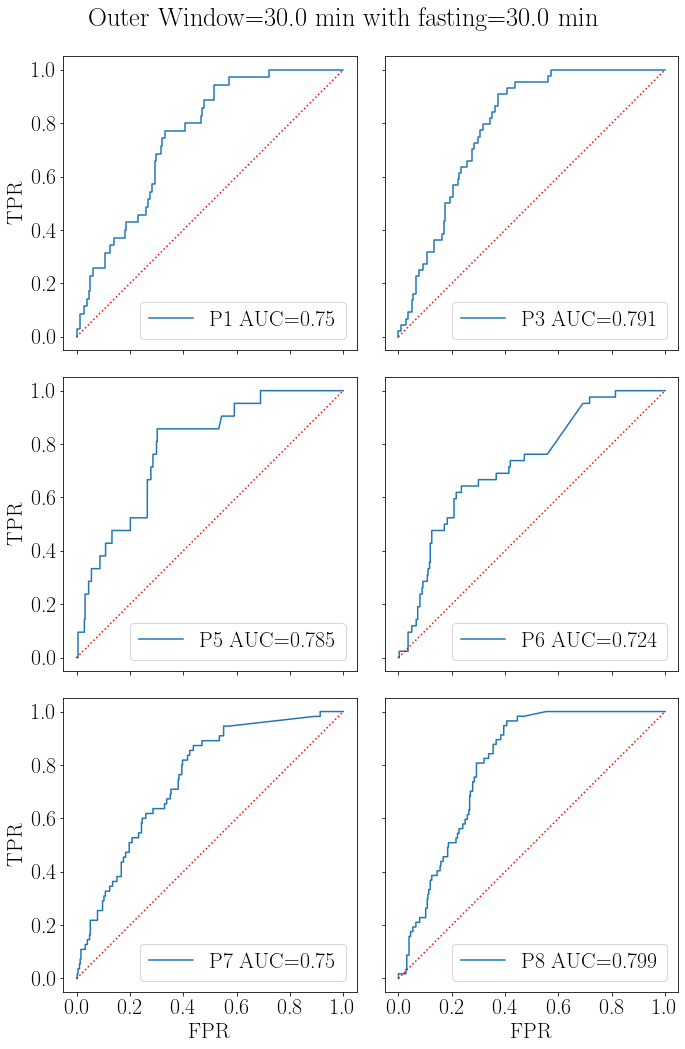

In [21]:
def meanSTDFinder(df):
    cmData = []
    for counter in range(len(df)):
        elements = df["CM"].iloc[counter]
        for element in elements:
            cmData.append(element)
    cmData = np.asarray(cmData).astype(float)
    cmDataMean = np.nanmean(cmData, axis=0)
    cmDataStd = np.nanstd(cmData, axis=0)
    return cmDataMean, cmDataStd


def cmNormalizerPredictor(element, cmDataMean, cmDataStd, hooverModel):
    element = np.asarray(element).astype(float)
    element -= cmDataMean
    element /= cmDataStd
    element = np.expand_dims(element, axis=0)
    hooverPrediction = hooverModel.predict_proba(element)
    hooverPrediction = hooverPrediction[0, 1]

    return hooverPrediction


def maxProbWinodFinder(tempPredictions):
    tempMax = -1
    for innerCounter in range(len(tempPredictions) - 5):
        tempArray = np.asarray(tempPredictions[innerCounter : innerCounter + 5])
        tempArray = np.mean(tempArray)
        if tempArray > tempMax:
            tempMax = tempArray
    return tempMax


def hooverPredictor(dfAllFeatures):
    hooverModelAdd = "/home/grads/s/sorush.omidvar/CGMDataset/Hoover/HooverModel-0.8.sav"
    hooverModel = pickle.load(open(hooverModelAdd, "rb"))
    hooverModel.n_jobs = coreNumber
    participants = dfAllFeatures["Participant"].to_list()
    participants = list(set(participants))
    participants.sort()
    dfTotal = []
    fig=plt.figure(figsize=(10, 15))
    subplotCounter = 1
    for participant in participants:
        dfTemp = dfAllFeatures[dfAllFeatures["Participant"] == participant]
        cmDataMean, cmDataStd = meanSTDFinder(dfTemp)

        predictions = []
        groundTruth = []
        for counter in tqdm(range(len(dfTemp))):
            elements = dfTemp["CM"].iloc[counter]
            tempPredictions = []
            for element in elements:
                tempPredictions.append(cmNormalizerPredictor(element, cmDataMean, cmDataStd, hooverModel))
            # predictions.append(maxProbWinodFinder(tempPredictions))
            dfTemp["CM"].iloc[counter] = maxProbWinodFinder(tempPredictions)
            # groundTruth.append(dfTemp["MealLabel"].iloc[counter])
        if len(dfTotal) != 0:
            frames = [dfTotal, dfTemp]
            dfTotal = pd.concat(frames)
        else:
            dfTotal = dfTemp
        predictions = dfTemp["CM"].to_list()
        groundTruth = dfTemp["MealLabel"].to_list()
        print("Total:", len(groundTruth), "Positive windows:", np.sum(groundTruth))
        fpr, tpr, thresholds = roc_curve(groundTruth, predictions, pos_label=1)
        print(roc_auc_score(groundTruth, predictions))
        plt.subplot(3, 2, subplotCounter)
        if subplotCounter%2==1:
            plt.ylabel("TPR")
            plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
        else:
            plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[])
        if subplotCounter>=5:
            plt.xlabel("FPR")
            plt.xticks([0,0.2,0.4,0.6,0.8,1.0],['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
        else:
            plt.xticks([0,0.2,0.4,0.6,0.8,1.0],[])
        
        plt.plot(fpr, tpr, label=participant.capitalize() + " AUC=" + str(np.round(roc_auc_score(groundTruth, predictions), 3)))
        plt.legend(loc="lower right")
        plt.plot([0, 1], [0, 1], "r:")
        subplotCounter += 1
    plt.suptitle("Outer Window="+ str(OUTTER_WINDOW_LENGTH.total_seconds()/60) + " min with fasting=" + str(FASTING_LENGTH.total_seconds()/60)+" min")
    fig.tight_layout()
    fig.savefig(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-ROC.jpg")),dpi=600)
    plt.show()
    return dfTotal


dfAllFeatures = pd.read_pickle(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
dfAllFeaturesHoover = hooverPredictor(dfAllFeatures)
dfAllFeaturesHoover.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features-AfterHoover.xlsx")), index=False)


In [22]:
def xgClassifier(xTrain, xTest, yTrain, yTest):
    clf = xgb.XGBClassifier(scale_pos_weight=len(yTrain) / np.sum(yTrain), n_jobs=coreNumber, n_estimators=250, max_depth=4, objective="binary:logistic", eval_metric="error",)
    clf.fit(xTrain, yTrain)

    predictionsTest = clf.predict_proba(xTest)
    predictionsTest = predictionsTest[:, 1]

    # fpr, tpr, thresholds = roc_curve(yTest, predictionsTest, pos_label=1)
    # plt.xlabel("FPR")
    # plt.ylabel("TPR")
    # plt.title("ROC-AUC:" + str(np.round(roc_auc_score(yTest, predictionsTest), 3)))
    # plt.scatter(fpr, tpr)
    # plt.plot([0, 0], [1, 1], color="red")
    # plt.show()

    predictionsTest[predictionsTest >= 0.5] = 1
    predictionsTest[predictionsTest < 0.5] = 0

    accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
    recall = sklearn.metrics.recall_score(yTest, predictionsTest)
    precision = sklearn.metrics.precision_score(yTest, predictionsTest)
    f1Score = sklearn.metrics.f1_score(yTest, predictionsTest, average="weighted")
    rocAuc = roc_auc_score(yTest, predictionsTest)

    # print(np.round(recall, 3), "\t", np.round(precision, 3), "\t", np.round(f1Score, 3), "\t", np.round(rocAuc, 3), "\t", len(yTest) - np.sum(yTest), "\t", np.sum(yTest), "\t", np.round(accuracy, 3))
    return [rocAuc, accuracy, recall, precision, f1Score, len(yTest) - np.sum(yTest), np.sum(yTest)]


def foldRunnerAux(df, xData, yData, xTrain, yTrain, xTest, yTest):
    tempVal = df["Train"].to_list()
    tempVal = np.asarray(tempVal).astype(int)
    tempVal = tempVal.flatten()
    if len(yTrain) == 0:
        xTrain = xData[tempVal, :]
        yTrain = yData[tempVal]
    else:
        xTrain = np.concatenate((xTrain, xData[tempVal, :]), axis=0)
        yTrain = np.concatenate((yTrain, yData[tempVal]), axis=0)

    tempVal = df["Test"].to_list()
    tempVal = np.asarray(tempVal).astype(int)
    tempVal = tempVal.flatten()
    if len(yTest) == 0:
        xTest = xData[tempVal, :]
        yTest = yData[tempVal]
    else:
        xTest = np.concatenate((xTest, xData[tempVal, :]), axis=0)
        yTest = np.concatenate((yTest, yData[tempVal]), axis=0)

    return xTrain, yTrain, xTest, yTest


def foldRunner(dfData, posXData, posYData, negXData, negYData, setData):
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []

    dfTemp = dfData[dfData["Set"] == setData]
    dfPos = dfTemp[dfTemp["Stat"] == "Pos"]
    xTrain, yTrain, xTest, yTest = foldRunnerAux(dfPos, posXData, posYData, xTrain, yTrain, xTest, yTest)

    dfTemp = dfData[dfData["Set"] == setData]
    dfNeg = dfTemp[dfTemp["Stat"] == "Neg"]
    xTrain, yTrain, xTest, yTest = foldRunnerAux(dfNeg, negXData, negYData, xTrain, yTrain, xTest, yTest)

    return xTrain, yTrain, xTest, yTest


def posNegSeparator(df, statLabel):
    dfTemp = df[df["MealLabel"] == statLabel]
    yDataBinary = dfTemp["MealLabel"].to_list()
    yDataBinary = np.asarray(yDataBinary).astype(float)

    dfTemp.drop(columns=["StartTime", "FinishTime", "MealLabel", "Participant", "Carb", "Fat", "Protein"], inplace=True)
    xDataBinary = dfTemp.values
    xDataBinary = np.asarray(xDataBinary).astype(float)
    return xDataBinary, yDataBinary


def foldMaker(statLabel, yData, dfTemp):
    setCounter = 0
    kf = KFold(n_splits=5, shuffle=False)
    for trainIndex, testIndex in kf.split(yData):
        dfTemp.append([statLabel, trainIndex, testIndex, setCounter])
        setCounter += 1
    return dfTemp


def testTrainSplit(dfParticipant, participant, combination, normalFlag):
    xDataPos, yDataPos = posNegSeparator(dfParticipant, 1)
    xDataNeg, yDataNeg = posNegSeparator(dfParticipant, 0)
    classifierReport = []
    if normalFlag:
        tempVal = np.concatenate((xDataNeg, xDataPos), axis=0)
        xDataNeg -= np.mean(tempVal, axis=0)
        xDataPos -= np.mean(tempVal, axis=0)

        xDataNeg /= np.std(tempVal, axis=0)
        xDataPos /= np.std(tempVal, axis=0)

    dfTemp = []
    dfTemp = foldMaker("Pos", yDataPos, dfTemp)
    dfTemp = foldMaker("Neg", yDataNeg, dfTemp)

    dfTemp = pd.DataFrame(dfTemp, columns=["Stat", "Train", "Test", "Set"])
    foldDatas = list(set(dfTemp["Set"].to_list()))

    setNumber = 0
    # print("Rec:\t", "Prec:\t", "F1:\t", "ROC:\t", "Neg:\t", "Pos:\t", "Acc:\t")
    for setData in foldDatas:
        xTrain, yTrain, xTest, yTest = foldRunner(dfTemp, xDataPos, yDataPos, xDataNeg, yDataNeg, setData)
        tempListReport = xgClassifier(xTrain, xTest, yTrain, yTest)
        tempListReport.extend([participant, combination, setNumber])
        classifierReport.append(tempListReport)
        setNumber += 1
    return classifierReport


def predictionMain(dfCombination, randomSeed, normalFlag, combination):
    participants = list(set(dfCombination["Participant"].to_list()))
    classifierReports = []
    # for participantCounter in tqdm(range(len(participants) + 1)):
    for participantCounter in range(len(participants)):
        if participantCounter == len(participants):  # General Model (one model for all participants)
            dfParticipant = dfCombination
            participant = "All"
        else:  # Personal Model (each participant have a his/her own model)
            participant = participants[participantCounter]
            dfParticipant = dfCombination[dfCombination["Participant"] == participant]
        dfParticipant.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
        print("*************************", "Participant:", participant)
        classifierReports.extend(testTrainSplit(dfParticipant, participant, combination, normalFlag))
    return classifierReports


def foldSummarizerBinary(df):
    combinations = list(set(df["Combination"].to_list()))
    participants = list(set(df["Participant"].to_list()))
    dfSummarizeds = []
    headers = ["Participant", "Combination", "ROC-AUC", "Accuracy", "Recall", "Precision", "F1", "TestPositive", "TestNegative", "SetNumber"]
    for participant in participants:
        for combination in combinations:
            dfSummarized = [participant, combination]
            dfTemp = df[(df["Participant"] == participant) & (df["Combination"] == combination)]
            assert len(dfTemp) == FOLD_NUMBER
            dfSummarized.extend(dfTemp.mean())
            dfSummarizeds.append(dfSummarized)
    dfSummarizeds = pd.DataFrame(dfSummarizeds, columns=headers)
    dfSummarizeds.drop(columns=["SetNumber"], inplace=True)
    dfSummarizeds.sort_values(["Participant", "Combination"], ascending=(True, True), inplace=True)
    dfSummarizeds.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier-Summary.xlsx"),), index=False)

    print("Outter:", str(OUTTER_WINDOW_LENGTH), "Fasting:", str(FASTING_LENGTH))
    print(("---------------------------------------------------------"))
    print(dfSummarizeds)


if os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx"))):
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")))
if not os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx"))):
    dfAllFeaturesHoover = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features-AfterHoover.xlsx")))
    combinations = [["CGM"], ["CM"], ["CGM", "CM"], ["CGM", "CM", "Temperature"], ["CGM", "CM", "Temperature", "HR", "EDA"]]
    columns = dfAllFeaturesHoover.columns
    headersClassifier = ["ROC-AUC", "Accuracy", "Recall", "Precision", "F1", "TestPositive", "TestNegative", "Participant", "Combination", "SetNumber"]
    dfClassifier = []
    for combination in combinations:
        columnList = ["StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"]
        for topic in combination:
            for column in columns:
                if topic in column:
                    columnList.append(column)

        dfCombination = dfAllFeaturesHoover[dfAllFeaturesHoover.columns.intersection(columnList)]
        randomSeed = 60
        print("----------------------")
        print("Combination:", "+".join(combination))
        NORMALIZED_FLAG = True
        classifierReport = predictionMain(dfCombination, randomSeed, NORMALIZED_FLAG, "+".join(combination))
        dfTempClassifier = pd.DataFrame(classifierReport, columns=headersClassifier)
        if len(dfClassifier) > 0:
            frames = [dfTempClassifier, dfClassifier]
            dfClassifier = pd.concat(frames)
        else:
            dfClassifier = dfTempClassifier

    dfClassifier.reset_index(drop=True, inplace=True)
    dfClassifier.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")), index=False)

else:
    dfClassifier = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")))
foldSummarizerBinary(dfClassifier)



----------------------
Combination: CGM
************************* Participant: p6
************************* Participant: p1
************************* Participant: p8
************************* Participant: p7
************************* Participant: p3
************************* Participant: p5
----------------------
Combination: CM
************************* Participant: p6
************************* Participant: p1
************************* Participant: p8
************************* Participant: p7
************************* Participant: p3
************************* Participant: p5
----------------------
Combination: CGM+CM
************************* Participant: p6
************************* Participant: p1
************************* Participant: p8
************************* Participant: p7
************************* Participant: p3
************************* Participant: p5
----------------------
Combination: CGM+CM+Temperature
************************* Participant: p6
*************************

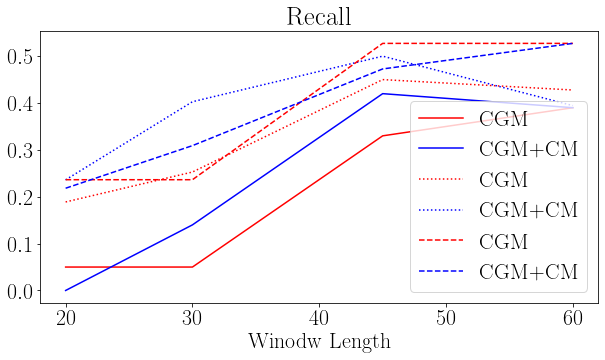

In [23]:
os.chdir(os.path.join(addDataPrefix, "Results"))


def summaryPlotter(participant, metricType):
    metricCGMList = []
    metricCGMCMList = []
    windowLenList = []
    for root, dirs, files in os.walk(os.path.join(addDataPrefix, "Results")):
        for file in sorted(files):
            if ".xlsx" in file.lower() and "summary" in file.lower() and "classifier" in file.lower():
                windowLen = file[: file.find("-")]

                dfTemp = pd.read_excel(file)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMList.append(metricVal)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM+CM")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMCMList.append(metricVal)
                windowLenList.append(windowLen)
    for counter in range(len(windowLenList)):
        tempVal = datetime.strptime(windowLenList[counter], "%H:%M:%S")
        tempVal = tempVal.time().hour * 60 + tempVal.time().minute
        windowLenList[counter] = tempVal
    return metricCGMList, metricCGMCMList, windowLenList


metricName = "Recall"
metricCGMList, metricCGMCMList, windowLenList = summaryPlotter("p5", metricName)
plt.figure(figsize=(10, 5))
plt.plot(windowLenList, metricCGMList, "-r", label="CGM")
plt.plot(windowLenList, metricCGMCMList, "-b", label="CGM+CM")

metricCGMList, metricCGMCMList, windowLenList = summaryPlotter("p6", metricName)
plt.plot(windowLenList, metricCGMList, ":r", label="CGM")
plt.plot(windowLenList, metricCGMCMList, ":b", label="CGM+CM")
plt.xlabel("Winodw Length")
plt.title(metricName)
plt.legend()

metricCGMList, metricCGMCMList, windowLenList = summaryPlotter("p7", metricName)
plt.plot(windowLenList, metricCGMList, "--r", label="CGM")
plt.plot(windowLenList, metricCGMCMList, "--b", label="CGM+CM")
plt.xlabel("Winodw Length")
plt.title(metricName)
plt.legend()
plt.show()


In [24]:
def rmseCalculator(trueGround, prediction):
    assert len(trueGround) == len(prediction)
    rmse = trueGround - prediction
    rmse = np.power(rmse, 2)
    rmse = np.sum(rmse) / len(rmse)
    rmse = np.sqrt(rmse)
    return rmse


def rmsleCalculator(trueGround, prediction):
    assert len(trueGround) == len(prediction)
    rmsle = np.log(trueGround + 1) - np.log(prediction + 1)
    rmsle = np.power(rmsle, 2)
    rmsle = np.sum(rmsle) / len(rmsle)
    rmsle = np.sqrt(rmsle)
    return rmsle


def xgRegression(xTrain, xTest, yTrain, yTest):
    clf = xgb.XGBRegressor(n_jobs=coreNumber, n_estimators=250, max_depth=4, objective="reg:squarederror")
    # clf = xgb.XGBRegressor(n_jobs=coreNumber, n_estimators=250, max_depth=4, objective="reg:squaredlogerror")
    clf.fit(xTrain, yTrain)

    predictionsTest = clf.predict(xTest)
    rmseValue = rmseCalculator(yTest, predictionsTest)
    rmsleValue = rmsleCalculator(yTest, predictionsTest)
    pearsonValue = pearsonr(yTest, predictionsTest)[0]
    # featureImportance = modelBest.feature_importances_
    # print("Pearson:\t", pearsonValue, "\tE:\t", rmseValue, "\tLogE:\t", rmsleValue)
    return [rmseValue, rmsleValue, pearsonValue, yTest, predictionsTest]


def dataFormatter(df, normalFlag):
    carbVal = df["Carb"].to_list()
    fatVal = df["Fat"].to_list()
    proteinVal = df["Protein"].to_list()

    carbVal = np.asarray(carbVal).astype(float)
    fatVal = np.asarray(fatVal).astype(float)
    proteinVal = np.asarray(proteinVal).astype(float)

    yDataRegression = np.empty((len(carbVal), 3))
    yDataRegression[:, 0] = carbVal
    yDataRegression[:, 1] = fatVal
    yDataRegression[:, 2] = proteinVal

    startTimeRegression = df["StartTime"].to_list()
    finishTimeRegresssion = df["FinishTime"].to_list()

    startTimeRegression = np.asarray(startTimeRegression)
    finishTimeRegresssion = np.asarray(finishTimeRegresssion)

    constituents = ["Carb", "Fat", "Protein"]

    df.drop(columns=["StartTime", "FinishTime", "MealLabel", "Participant", "Carb", "Fat", "Protein"], inplace=True)
    xDataRegression = df.values
    xDataRegression = np.asarray(xDataRegression).astype(float)

    if normalFlag:
        xDataRegression -= np.mean(xDataRegression, axis=0)
        xDataRegression /= np.std(xDataRegression, axis=0)

    return xDataRegression, yDataRegression, constituents, startTimeRegression, finishTimeRegresssion


def testTrainSplitRegression(dfParticipant, participant, combination, normalFlag):
    xDataRegression, yDataRegression, constituents, startTimeRegression, finishTimeRegresssion = dataFormatter(dfParticipant, normalFlag)
    setCounter = 0
    kf = KFold(n_splits=5, shuffle=False)
    regressionReport = []
    for trainIndex, testIndex in kf.split(yDataRegression):
        xTrain = xDataRegression[trainIndex, :]
        xTest = xDataRegression[testIndex, :]
        tempList = []
        for counter in range(len(constituents)):
            yTrain = yDataRegression[trainIndex, counter]
            yTest = yDataRegression[testIndex, counter]

            startTimeTrain = startTimeRegression[trainIndex]
            startTimeTest = startTimeRegression[testIndex]

            tempList = xgRegression(xTrain, xTest, yTrain, yTest)
            tempList.extend([participant, combination, startTimeTrain, startTimeTest, setCounter, constituents[counter]])
            regressionReport.append(tempList)
        setCounter += 1

    return regressionReport


def predictionRegressionMain(dfCombination, normalFlag, combination):
    participants = list(set(dfCombination["Participant"].to_list()))
    regressionReports = []
    for participantCounter in range(len(participants)):
        if participantCounter == len(participants):  # General Model (one model for all participants)
            dfParticipant = dfCombination
            participant = "All"
        else:  # Personal Model (each participant have a his/her own model)
            participant = participants[participantCounter]
            dfParticipant = dfCombination[dfCombination["Participant"] == participant]
        dfParticipant.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
        print("*************************", "Participant:", participant)
        regressionReports.extend(testTrainSplitRegression(dfParticipant, participant, combination, normalFlag))

    return regressionReports


def foldSummarizerRegression(df):
    combinations = list(set(df["Combination"].to_list()))
    components = list(set(df["Component"].to_list()))
    participants = list(set(df["Participant"].to_list()))
    dfSummarizeds = []
    headers = ["Participant", "Combination", "Component", "RMSE", "RMSLE", "Pearson", "SetNumber"]
    for participant in participants:
        for component in components:
            for combination in combinations:
                dfSummarized = [participant, combination, component]
                dfTemp = df[(df["Participant"] == participant) & (df["Combination"] == combination) & (df["Component"] == component)]
                assert len(dfTemp) == FOLD_NUMBER
                dfSummarized.extend(dfTemp.mean())
                dfSummarizeds.append(dfSummarized)
    dfSummarizeds = pd.DataFrame(dfSummarizeds, columns=headers)
    dfSummarizeds.drop(columns=["SetNumber"], inplace=True)
    dfSummarizeds.sort_values(["Participant", "Component", "Combination"], ascending=(True, True, True), inplace=True)
    dfSummarizeds.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regression-Summary.xlsx"),), index=False)

    print("Outter:", str(OUTTER_WINDOW_LENGTH), "Fasting:", str(FASTING_LENGTH))
    print(("---------------------------------------------------------"))
    print(dfSummarizeds)


if os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx"))):
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")))
if not os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx"))):
    dfAllFeaturesHoover = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features-AfterHoover.xlsx")))
    dfAllFeaturesHoover = dfAllFeaturesHoover[dfAllFeaturesHoover["MealLabel"] == 1]

    combinations = [["CGM"], ["CGM", "HR", "Temperature"]]
    columns = dfAllFeaturesHoover.columns
    headersRegression = ["RMSE", "RMSLE", "Pearson", "TrueMacro", "PredictedMacro", "Participant", "Combination", "StartTime", "FinishTime", "SetNumber", "Component"]
    dfRegression = []

    for combination in combinations:
        columnList = ["StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"]
        for topic in combination:
            for column in columns:
                if topic in column:
                    columnList.append(column)

        dfCombination = dfAllFeaturesHoover[dfAllFeaturesHoover.columns.intersection(columnList)]
        print(dfCombination.columns)
        raise
        randomSeed = 60
        print("----------------------")
        print("Combination:", "+".join(combination))
        NORMALIZED_FLAG = True
        regressionReports = predictionRegressionMain(dfCombination, NORMALIZED_FLAG, "+".join(combination))
        dfTempRegression = pd.DataFrame(regressionReports, columns=headersRegression)
        if len(dfRegression) > 0:
            frames = [dfTempRegression, dfRegression]
            dfRegression = pd.concat(frames)
        else:
            dfRegression = dfTempRegression
    dfRegression.reset_index(drop=True, inplace=True)
    dfRegression.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")), index=False)
else:
    dfRegression = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")))
foldSummarizerRegression(dfRegression)


Index(['CGM-Mean', 'CGM-Std', 'CGM-Min', 'CGM-Max', 'CGM-Range',
       'CGM-Skewness', 'CGM-Kurtosis', 'StartTime', 'FinishTime',
       'Participant', 'Carb', 'Fat', 'Protein', 'MealLabel'],
      dtype='object')


RuntimeError: No active exception to reraise

In [ ]:
os.chdir(os.path.join(addDataPrefix, "Results"))


def summaryPlotter(participant, metricType, component):
    metricCGMList = []
    windowLenList = []
    for root, dirs, files in os.walk(os.path.join(addDataPrefix, "Results")):
        for file in sorted(files):
            if ".xlsx" in file.lower() and "summary" in file.lower() and "regression" in file.lower():
                windowLen = file[: file.find("-")]
                dfTemp = pd.read_excel(file)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM") & (dfTemp["Component"] == component)]

                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMList.append(metricVal)
                windowLenList.append(windowLen)

    for counter in range(len(windowLenList)):
        tempVal = datetime.strptime(windowLenList[counter], "%H:%M:%S")
        tempVal = tempVal.time().hour * 60 + tempVal.time().minute
        windowLenList[counter] = tempVal

    return metricCGMList, windowLenList


metricName = "RMSLE"
plt.figure(figsize=(10, 5))

metricCGMList, windowLenList = summaryPlotter("p1", metricName, "Fat")
plt.plot(windowLenList, metricCGMList, "-g", label="Fat")

metricCGMList, windowLenList = summaryPlotter("p1", metricName, "Carb")
plt.plot(windowLenList, metricCGMList, "-r", label="Carb")


metricCGMList, windowLenList = summaryPlotter("p1", metricName, "Protein")
plt.plot(windowLenList, metricCGMList, "-b", label="Protein")


plt.xlabel("Winodw Length")
plt.title(metricName)
plt.legend()
plt.show()

